In [ ]:
!pip install kaggle


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!mv kaggle1.json ~/.kaggle/

mv: cannot move 'kaggle1.json' to '/root/.kaggle/': Not a directory


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!unzip -q "chest-xray-pneumonia.zip"

unzip:  cannot find or open chest-xray-pneumonia.zip, chest-xray-pneumonia.zip.zip or chest-xray-pneumonia.zip.ZIP.


In [ ]:
# Imports required for this project
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [ ]:
# Creating the Pathlib PATH objects
train_path = Path("chest_xray/train/")
validation_path = Path("chest_xray/test")
test_path = Path("chest_xray/val")

In [ ]:
# Collecting all the Paths Inside "Normal" and "Pneumonia" folders of the above paths
train_image_paths = train_path.glob("*/*")
val_image_paths = validation_path.glob("*/*")

# Output is a Generator object
print(train_image_paths)

<generator object Path.glob at 0x7c38082f3530>


In [ ]:
# Convert Generator Object to List of elements
train_image_paths = list(train_image_paths)
val_image_paths = list(val_image_paths)

# Now the outputs are "PosixPath" objects
print(train_image_paths[:3])

[PosixPath('chest_xray/train/NORMAL/NORMAL2-IM-0869-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/NORMAL2-IM-0543-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/IM-0370-0001.jpeg')]


In [ ]:
# Convert Posix paths to normal strings
train_image_paths = list(map(lambda x : str(x) , train_image_paths))
val_image_paths = list(map(lambda x : str(x) , val_image_paths))

print(train_image_paths[:3])

['chest_xray/train/NORMAL/NORMAL2-IM-0869-0001.jpeg', 'chest_xray/train/NORMAL/NORMAL2-IM-0543-0001.jpeg', 'chest_xray/train/NORMAL/IM-0370-0001.jpeg']


In [ ]:
# Collect Length for Training and Validation Datasets
train_dataset_length = len(train_image_paths)
val_dataset_length = len(val_image_paths)

In [ ]:
# Every Image has Label in its path , so lets slice it
LABELS = {'NORMAL' : 0 , 'PNEUMONIA' : 1}
INV_LABELS = {0 : 'NORMAL', 1 : 'PNEUMONIA'}

def get_label(path : str) -> int:
    return LABELS[path.split("/")[-2]]

train_labels = list(map(lambda x : get_label(x) , train_image_paths))
val_labels = list(map(lambda x : get_label(x) , val_image_paths))

print(train_labels[:3])

[0, 0, 0]


In [ ]:
# Now we have all training, validation image paths and their respective labels

BATCH_SIZE = 32

# Function used for Transformation
def load_and_transform(image , label , train = True):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [224 , 224] , method="nearest")
    if train:
        image = tf.image.random_flip_left_right(image)
    return image , label

# Function used to Create a Tensorflow Data Object
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset)).shuffle(1000)

    dataset = dataset.map(lambda image , label : load_and_transform(image , label , train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

In [ ]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(train_image_paths , train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 101 ms, sys: 1.86 ms, total: 103 ms
Wall time: 103 ms
(32, 224, 224, 3)
(32,)


In [ ]:
train_dataset = get_dataset(train_image_paths , train_labels)
print(len(train_dataset))

0


In [ ]:
def load_and_transform(image, label, train):
    # Implement the function body here
    # ...
    return image, label

image, label = next(iter(train_dataset))
image, label = load_and_transform(image, label, train=True)
print(image.shape)
print(label.shape)

(32, 224, 224, 3)
(32,)


NORMAL


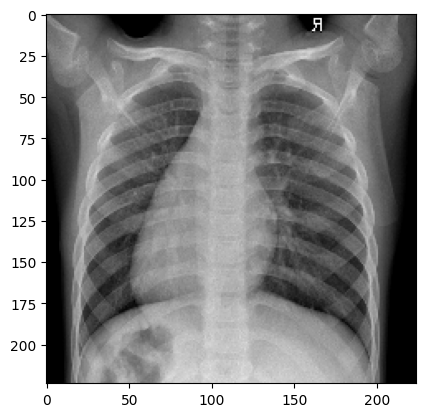

In [ ]:
# View a sample Train Image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [ ]:
%time val_dataset = get_dataset(val_image_paths , val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 38.9 ms, sys: 998 µs, total: 39.9 ms
Wall time: 38.7 ms
(32,)
(32,)


In [ ]:
# View a sample Validation Image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

PNEUMONIA


AttributeError: 'bytes' object has no attribute 'reshape'

In [ ]:
# Building ResNet50 model
from tensorflow.keras.applications import ResNet50V2

backbone = ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

94668760/94668760 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23566849 (89.90 MB)
Trainable params: 23521409 (89.73 MB)
Non-trainable params: 45440 (177.50 KB)
_________________________________________________________________


In [ ]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'binary_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
# Defining our callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_length//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = val_dataset_length//BATCH_SIZE,
)

In [ ]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_length//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = val_dataset_length//BATCH_SIZE,
)

Epoch 1/8


KeyboardInterrupt: 

NameError: name 'history' is not defined

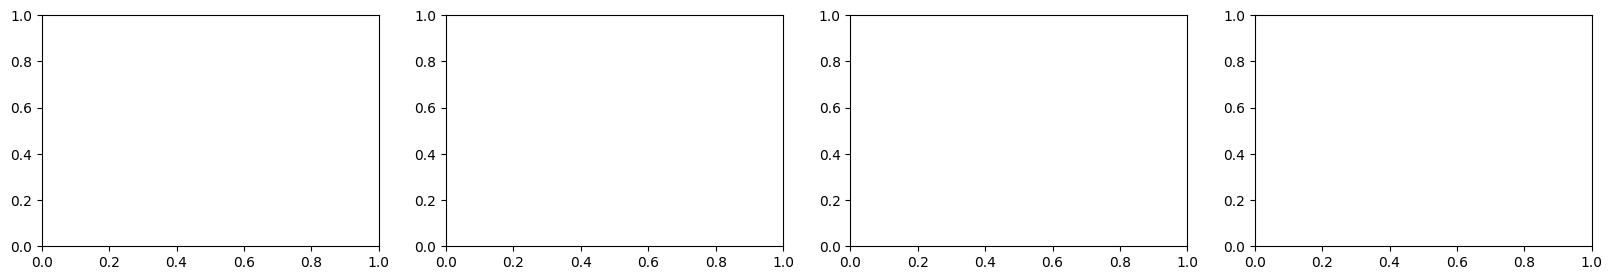

In [ ]:
# Interpreting the Metrics
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
# Saving the best Model

# Load the best weights
model.load_weights("best_weights.h5")
# Save the whole model (weigths + architecture)
model.save("model.h5")

In [ ]:
# Loading the whole model
loaded_model = tf.keras.models.load_model("model.h5")

Create a Testing Dataset

In [ ]:
# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [224 , 224] , method="nearest")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [ ]:
# Verify Test Dataset Object
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(16, 224, 224, 3)
(16,)


PNEUMONIA


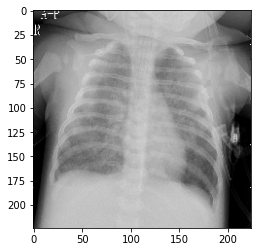

In [ ]:
# View a sample Validation Image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [ ]:
# Evaluating the loaded model
loss, acc, prec, rec = loaded_model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

1/1 [==============================] - 0s 2ms/step - loss: 0.4424 - accuracy: 0.7500 - precision: 0.7000 - recall: 0.8750
 Testing Acc :  0.75
 Testing Precision  0.699999988079071
 Testing Recall  0.875
